<a href="https://colab.research.google.com/github/SwarajShinde/Buyers-s-Time-Prediction-Challenge/blob/main/Regression_Torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import re
import seaborn as sns
import sklearn
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Regress/train_encoded.csv')
test = pd.read_csv('/content/drive/MyDrive/Regress/test_encoded.csv')
sub = pd.read_csv("/content/drive/MyDrive/Regress/reg_problems/ParticipantData_BTPC/Sample Submission.csv")

In [ ]:
print(train.head(5))
train.isna().sum()

                         session_id  ... month
0  57f879e70d3c5fc2a98102d64c9fd84e  ...     1
1  a5442b0c7c33d0a811e7661e556b2de8  ...     2
2  305cb1486ed8610c00b37007926cb2c4  ...     8
3  f2c1ecc9993f0071df91ba178450498c  ...    12
4  e460830ae295e55d2216ebdc761ab9a6  ...     9

[5 rows x 10 columns]


session_id          0
client_agent      160
device_details      0
date                0
purchased           0
added_in_cart       0
checked_out         0
time_spent          0
client_mod          0
month               0
dtype: int64

In [ ]:
train.drop('client_agent',axis=1,inplace=True)

KeyError: ignored

In [ ]:
train.isna().sum()


session_id        0
device_details    0
date              0
purchased         0
added_in_cart     0
checked_out       0
time_spent        0
client_mod        0
month             0
dtype: int64

In [ ]:
from torch.utils.data import DataLoader,Dataset
from tqdm.notebook import tqdm
import torch.optim as optim
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

In [ ]:
x=torch.tensor([1])
y=torch.tensor([2])
z=torch.stack((x,y),dim=1)
z

tensor([[1, 2]])

In [ ]:
features = ['device_details','purchased','added_in_cart','checked_out','client_mod','month']
target = ['time_spent']

In [ ]:
train.shape[0]

5429

In [ ]:
ko = train.iloc[3]
ko['session_id']
loko = ko[features].tolist()
torch_tn = torch.tensor(loko)
torch_tn

tensor([ 8,  0,  1,  0,  2, 12])

In [ ]:

# Loss Function: RMLSE
class RMLSE(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
    def forward(self,pred,act):
        return torch.sqrt(self.mse(torch.log(pred+1),torch.log(act+1)))


In [ ]:
class RegressionDataset(Dataset):
    def __init__(self,df,feats):
        self.df=df
        self.feats=feats

    def __len__(self):

        return self.df.shape[0]

    def __getitem__(self,idx):
        data = self.df.iloc[idx]
        target = torch.tensor(data['time_spent'],dtype=torch.float32)
        features = torch.tensor(data[self.feats].tolist(),dtype=torch.float32)
        return features,target

In [ ]:

temp_train = train[:50]

In [ ]:
temp_ds = RegressionDataset(df=temp_train,feats=features)


In [ ]:
temp_dl = DataLoader(temp_ds,batch_size=4,shuffle=False)


In [ ]:
train_,val_ = train_test_split(train,test_size=0.2)

In [ ]:
train_ds = RegressionDataset(df=train_,feats=features)
valid_ds = RegressionDataset(df=val_,feats=features)

In [ ]:
train_dl = DataLoader(train_ds,batch_size=32,shuffle=True,num_workers=2)
valid_dl = DataLoader(valid_ds,batch_size=32,shuffle=False,num_workers=2)

In [ ]:
# nn Architecture
class REModel(nn.Module):
    def __init__(self,num_feats):
        super().__init__()
        self.layer1 = nn.utils.weight_norm(nn.Linear(num_feats,16))
        self.layer2=nn.utils.weight_norm(nn.Linear(16,32))
        self.layer3=nn.utils.weight_norm(nn.Linear(32,16))
        self.dropout1 = nn.Dropout(0.20)
        self.layer4=nn.Linear(16,1)
        self.relu = nn.ReLU()
    def forward(self,inputs):
        x=self.relu(self.layer1(inputs))
        x=self.dropout1(x)
        x=self.relu(self.layer2(x))
        x=self.dropout1(x)
        x=self.relu(self.layer3(x))
        x=self.dropout1(x)
        x=self.relu(self.layer4(x))
        return x



In [ ]:
class Model(nn.Module):
    def __init__(self, num_features, hidden_size):
        super(Model, self).__init__()
        self.batch_norm1 = nn.BatchNorm1d(num_features)
        self.dropout1 = nn.Dropout(0.15)
        self.dense1 = nn.utils.weight_norm(nn.Linear(num_features, hidden_size))
        
        self.batch_norm2 = nn.BatchNorm1d(hidden_size)
        self.dropout2 = nn.Dropout(0.15)
        self.dense2 = nn.Linear(hidden_size, hidden_size)
        
        self.batch_norm3 = nn.BatchNorm1d(hidden_size)
        self.dropout3 = nn.Dropout(0.15)
        self.dense3 = nn.utils.weight_norm(nn.Linear(hidden_size, 1))
    
    def forward(self, x):
        #x = self.batch_norm1(x)
        x = self.dropout1(x)
        x = F.leaky_relu(self.dense1(x))
        
       # x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = F.leaky_relu(self.dense2(x))
        
        #x = self.batch_norm3(x)
        x = self.dropout3(x)
        x = self.dense3(x)
        
        return x

In [ ]:
model=REModel(num_feats=6)
DEVICE='cuda'
criterion = RMLSE()
optimzer=torch.optim.Adam(model.parameters(),lr=0.001)



In [ ]:
# train one epoch
def train_fn(loader,device,model,criterion,optimizer):
    train_epoch_loss = AverageMeter()
    ops = []
    model = model.to(device)
    model.train()
    tk0 = tqdm(loader,total = len(loader))
    for inps,tars in tk0:
        inps=inps.to(device)
        tars=tars.to(device)
        output = model(inps)
        losses=criterion(output,tars)
        train_epoch_loss.update(losses.item(),n=1)
        losses.backward()
        optimizer.step()
        optimizer.zero_grad()

    return train_epoch_loss.avg



In [ ]:
# train one epoch
def valid_fn(loader,device,model,criterion):
    metric = AverageMeter()
    model=model.to(device)
    model.eval()
    tk0 = tqdm(loader,total = len(loader))
    for inps,tars in tk0:
        inps=inps.to(device)
        tars=tars.to(device)
        output = model(inps)
        losses=criterion(output,tars)
        metric.update(losses.item(),n=1)
    return metric.avg



In [ ]:
x,y=next(iter(train_dl))
model(x)

In [ ]:
print(f'features_data_type : {x.dtype} target_data_type : {y.dtype}')

features_data_type : torch.float32 target_data_type : torch.float32


In [ ]:
x1= train_fn(loader=train_dl,device=DEVICE,model=model,criterion=criterion,optimizer=optimzer)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [ ]:
x1

3.3110058307647705

In [ ]:
class AverageMeter:
    def __init__(self):
        self.val = 0
        self.avg=0
        self.count=0
        self.sum=0
    def update(self,val,n=1):
        self.val = val
        self.sum += self.val*n
        self.count += n
        self.avg = self.sum/self.count
    def reset(self):
        self.val=0
        self.avg=0
        self.count=0
        self.sum=0

In [ ]:
# the training Loop
def run(epochs=1):
    best_valid_loss = 1000
    full_train_loss = []
    full_valid_loss = []
    for epoch in range(epochs):
        train_loss= train_fn(loader=train_dl,device=DEVICE,model=model,criterion=criterion,optimizer=optimzer)
        full_train_loss.append(train_loss)
        print(f'epoch {epoch} Train_loss:{train_loss}')
        valid_metric = valid_fn(loader=valid_dl,device=DEVICE,model=model,criterion=criterion)
        full_valid_loss.append(valid_metric)
        print(f'epoch {epoch} valid_loss:{valid_metric}')
        if valid_metric < best_valid_loss:
            best_valid_loss = valid_metric
            torch.save(model.state_dict(),f'best_weights{epoch}.bin')
    return full_train_loss,full_valid_loss
        

In [ ]:
# inference

In [ ]:
tl,vl = run(50)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

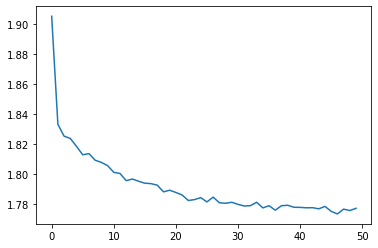

In [ ]:
plt.plot(tl)

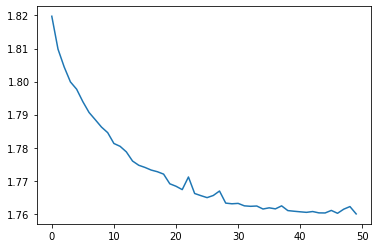

In [ ]:
plt.plot(vl)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# train one epoch
def inference_fn(loader,device,model):
    ops = []
    model=model.to(device)
    model.eval()
    tk0 = tqdm(loader,total = len(loader))
    for inps in tk0:
        inps=inps.to(device)
        output = model(inps)
        ops.extend(output.tolist())
    return ops



In [ ]:
class TestDataset(Dataset):
    def __init__(self,df,feats):
        self.df=df
        self.feats=feats

    def __len__(self):

        return self.df.shape[0]

    def __getitem__(self,idx):
        data = self.df.iloc[idx]
        features = torch.tensor(data[self.feats].tolist(),dtype=torch.float32)
        return features

In [ ]:
test_ds = TestDataset(df=test,feats=features)

In [ ]:
test_dl=DataLoader(test_ds,batch_size=32,shuffle=False,num_workers=2)

In [ ]:
#model.load_state_dict(torch.load('/content/best_weights9.bin'))

In [ ]:
outputs_ = inference_fn(loader=test_dl,device=DEVICE,model=model)

In [ ]:
len(outputs_)

2327

In [ ]:
output = []
def reemovNestings(l): 
    for i in l: 
        if type(i) == list: 
            reemovNestings(i) 
        else: 
            output.append(i) 

In [ ]:
reemovNestings(outputs_)

In [ ]:
output

In [ ]:
sub['time_spent'] = output

In [ ]:
sub.to_csv('weight_normalized.csv',index=False)

In [ ]:
subs2 = pd.read_csv('/content/avg_ensemble.csv')
subs1 = pd.read_csv('/content/pytorch_sub3.csv')


In [ ]:
subs2.head(n=5)

,time_spent
0,128.888641
1,103.031109
2,162.269379
3,106.476639
4,106.607327


In [ ]:
subs1.head(n=5)

,time_spent
0,164.588379
1,149.305389
2,170.198792
3,152.704208
4,158.373611


In [ ]:
avg_sum = subs1['time_spent']+subs2['time_spent']
avg_sum = avg_sum/2

In [ ]:
sub['time_spent'] = avg_sum
sub.to_csv('blend.csv',index=False)

In [ ]:
import shutil,os
shutil.copy('/content/best_weights_(cuurent_pytorch).bin','/content/drive/MyDrive/Regress/reg_problems')

'/content/drive/MyDrive/Regress/reg_problems/best_weights_(cuurent_pytorch).bin'

In [ ]:
shutil.copy('/content/normalized_weights.bin','/content/drive/MyDrive/Regress/reg_problems')

'/content/drive/MyDrive/Regress/reg_problems/normalized_weights.bin'

In [ ]:
jok=[10,11,12,13,15,16,17,18,19,2,20,23,25,3,32,35,36,4,44,42,46,5,6,7,8,9]
for i in jok:
    os.remove(f'/content/best_weights{i}.bin')